<a href="https://colab.research.google.com/github/YuxingW/machine_learning/blob/main/hw10/combine_factors_and_data_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## HW10 Pipeline

Factor: Sychology Utilities
* Sentiment
* Group confirmation

Reference: 
* https://towardsai.net/p/nlp/sentiment-analysis-opinion-mining-with-python-nlp-tutorial-d1f173ca4e3c
* https://github.com/towardsai/tutorials/tree/master/sentiment_analysis_tutorial
* https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/


## Data preparation
* Scrape data from politifact
* Fetch twitter tweets by APIs

###Scrape data from politifact

In [1]:
!pip install -q beautifulsoup4
!pip install -q vaderSentiment

     |████████████████████████████████| 133kB 9.1MB/s 


In [2]:
import requests 
import pandas as pd 
from bs4 import BeautifulSoup  

In [3]:
#Get all issues

url = "https://www.politifact.com/issues/"
issues = []
r = requests.get(url)
soup = BeautifulSoup(r.text,'html.parser')
results = soup.find_all('div', attrs={'class':'c-chyron__value'})
for result in results:
  name = result.find('a').text
  issue = result.find('a')['href'].replace("/","")
  issues.append((name, issue))

In [4]:
url = "https://www.politifact.com/factchecks/list/?page={pgno}&category={category}"

records = []  

for i in range(1,2):
  for issue, issue_url in issues[:5]:
    fUrl = url.format(pgno=str(i), category=issue_url)
    r = requests.get(fUrl)
    soup = BeautifulSoup(r.text, 'html.parser')  
    results = soup.find_all('article', attrs={'class':'m-statement'})
    for result in results:
      date = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[1].rstrip("\n")
      reporter = result.find('footer',attrs={'class':'m-statement__footer'}).text.split("•")[0].replace("\nBy","")   
      author = result.find('a',attrs={'class':'m-statement__name'}).text.replace("\n","")
      statement =  result.find('div', attrs = {'class':'m-statement__quote'}).find('a').text.replace("\n","")
      statement_descr = result.find('div', {'class':'m-statement__desc'}).text.replace("\n","")
      article_url =  result.find('a')['href']
      verdict = result.find('img', attrs = {'class':'c-image__thumb'}, alt=True).attrs['alt']
      records.append(( date, issue, reporter, author, statement, statement_descr, verdict, article_url))
  
df_sample = pd.DataFrame(records, columns=['Date', 'Issue','Reporter','Author', 'Statement', 'Description', 'Verdict', 'Url'])  
df_sample.head()

,Date,Issue,Reporter,Author,Statement,Description,Verdict,Url
0,"March 31, 2021",Abortion,Tom Kertscher,Facebook posts,“Joe Biden puts pro-life groups on domestic ex...,"stated on March 29, 2021 in a Facebook post:",barely-true,/personalities/facebook-posts/
1,"February 12, 2021",Abortion,Brandon Mulder,Greg Abbott,“Innocent lives will be saved” by ending taxpa...,"stated on January 24, 2021 in a tweet:",false,/personalities/greg-abbott/
2,"November 18, 2020",Abortion,Noah Y. Kim,Facebook posts,There is “aborted male fetus” in the Oxford-As...,"stated on November 15, 2020 in a Facebook post:",false,/personalities/facebook-posts/
3,"October 14, 2020",Abortion,Tom Kertscher,Tommy Tuberville,"Says Doug Jones ""has voted to spend our tax do...","stated on October 8, 2020 in an ad:",false,/personalities/tommy-tuberville/
4,"October 13, 2020",Abortion,Chris Nichols,Facebook posts,“Kamala Harris Tried to Put Pro-Lifers in Jail...,"stated on August 14, 2020 in a headline:",false,/personalities/facebook-posts/


In [5]:
df_sample.isnull().sum()

Date           0
Issue          0
Reporter       0
Author         0
Statement      0
Description    0
Verdict        0
Url            0
dtype: int64

**Import Required Packages**

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import requests
import string
from string import punctuation
from io import BytesIO
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Load less biased twitter data set for training**

In [7]:
train_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT-7fkaGbvXcppizTYkyM_weWptbtyab7PVUXJZdpJb7aJ-mKXtB1zTkY7DizLU7M64oYMoE8lPJQ1V/pub?output=csv'
r = requests.get(train_url)
data = r.content
df_train = pd.read_csv(BytesIO(data))
df_train.shape

(762, 3)

###Scrape data from twitter

In [8]:
!pip install -q datasketch
!pip install -q networkx 

     |████████████████████████████████| 71kB 4.5MB/s 


In [9]:
import tweepy
from tweepy import OAuthHandler
import pandas as pd
import numpy as np
import re
import time
from datasketch import MinHash, MinHashLSH

In [10]:
access_token = '1311987544507084800-iYuPqERzopIZuuyxaZ8xnqARcyKrR1'
access_token_secret = 'DCJg5kE7srBZRToNlzF0xqT3hcxonnXMlMXKWjX91wyTe'
consumer_key = 'YQLJJb0ELY5pdXbx7WkQXtRXo'
consumer_secret = 'HCgQga7Mj33C5E19IP7Dr3qGChmc85M6IEYXSGtI6g4cdplBYw'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

tweets = []

count = 1

"""if you don't add since= as one of the parameters, Twitter will sample the last 7 days worth of data depending
on how many total tweets there are with the specific hashtag, keyword, or key phrase that you are looking for. You can
manually add in the number of items (or tweets) you want to get back in the items() section."""

for tweet in tweepy.Cursor(api.search, q="#breaking", count=450, since='2020-04-10', lang='en').items(5000):
  count += 1
  try:
    data = [tweet.text, tweet.retweet_count, tweet.user.followers_count]
    data = tuple(data)
    tweets.append(data)
  
  except tweepy.TweepError as e:
    print(e.reason)
    continue

  except StopIteration:
    break

df_tweet = pd.DataFrame(tweets, columns = ['Statement', 'NumOfRetweets', 'UserNumOfFollowers'])
df_tweet = df_tweet[:1000]
df_tweet.head()

,Statement,NumOfRetweets,NumOfFavorites,UserNumOfFollowers,AuthorFollowers
0,RT @MeghUpdates: #BREAKING : BJP Madal Secreta...,4490,0,2085,2085
1,RT @TimesNow: #Breaking | @RahulGandhi hits ou...,7,0,1,1
2,RT @SomaliGuardian: #BREAKING: #Sudan’s milita...,134,0,13,13
3,"RT @WorldNewsLive_: #SOScolombia May 6,2021, C...",9,0,182,182
4,RT @WorldNewsLive_: 🟩(1) HOSTAGE RELEASED\n⛔NO...,2,0,182,182


**Text Preprocessing**

In [11]:
df = df_tweet.copy()

In [12]:
def get_text_processing(text):
    stpword = stopwords.words('english')
    stpword.append(['breaking', 'BREAKING'])
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

In [13]:
df['Statement'] = df['Statement'].apply(get_text_processing)
df_sample['Statement'] = df_sample['Statement'].apply(get_text_processing)


##Individual Factors

### Microfactors generation (Yuxing)

**1. Confirmation generation**

The more retweets, the more social confirmation. We split the number of retwees to 'Confirmation' as 'positive' and 'negative', 300 is the threshold we can use for a 'strong' confirmation or not.

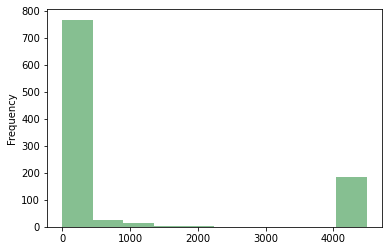

In [14]:
pd.options.mode.chained_assignment = None

ulimit = np.percentile(df.NumOfRetweets, 99)
df['NumOfRetweets'].loc[df['NumOfRetweets']>ulimit] = ulimit
llimit = np.percentile(df.NumOfRetweets.values, 1)
df['NumOfRetweets'].loc[df['NumOfRetweets']<llimit] = llimit
df['NumOfRetweets'].plot.hist(color='#86bf91')

In [15]:
def gen_microfactor_confirmation(df):
  df['ScaleConfirmation'] = df['NumOfRetweets']/df['NumOfRetweets'].mean()
  df['ScaleConfirmation'] = df['ScaleConfirmation'].apply(lambda x: 1 if x > 1 else x)
  df['Confirmation'] = df['ScaleConfirmation'].apply(lambda x: 'Positive' if x > 0.2 else 'Negative')

gen_microfactor_confirmation(df)

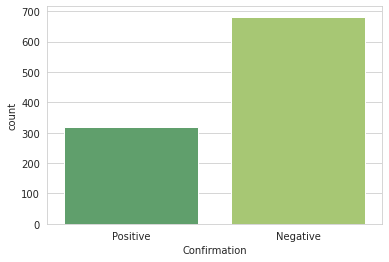

In [16]:
sns.set_style('whitegrid')
sns.countplot(x='Confirmation',data=df, palette='summer')

**2. Sentiment Generation**

We use SentimentIntensityAnalyzer to detect the score of sentiment.

In [17]:
def get_text_sentiment(text):
  analyzer = SentimentIntensityAnalyzer()
  _sentiment = analyzer.polarity_scores(text)["compound"]
  return abs(_sentiment)

In [18]:
df['ScaleSentiment'] = df['Statement'].apply(get_text_sentiment)
df['Sentiment'] = df['ScaleSentiment'].apply(lambda x: 'Positive' if float(x) > 0.4 else 'Negative')

**Visualize Sentiment Polarity**

**3. Opinion Leader**

The opinion leaders are people who have many followers, we will use use number of followers of twitter user to detect the score of opinion leader.

In [19]:
def gen_microfactor_opinionleader(df):
  df['ScaleOpinionLeader'] = df['UserNumOfFollowers']/df['UserNumOfFollowers'].mean()
  df['ScaleOpinionLeader'] = df['ScaleOpinionLeader'].apply(lambda x: 1 if x > 1 else x)
  df['OpinionLeader'] = df['ScaleOpinionLeader'].apply(lambda x: 'Positive' if x > 0.2 else 'Negative')

gen_microfactor_opinionleader(df)

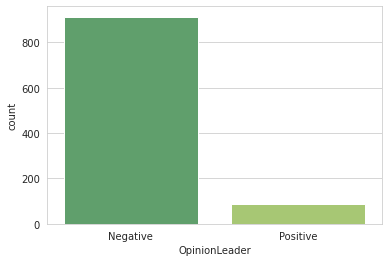

In [20]:
sns.set_style('whitegrid')
sns.countplot(x='OpinionLeader',data=df, palette='summer')

### Factor generation(Yuxing)
* Combine micro-factors to factor PsychologyUtilites using polynomial

In [21]:
# Get factor from micro factors by polynomial
df['ScalePsychology'] = df['ScaleConfirmation'] * 0.34 + df['ScaleSentiment'] * 0.33 + df['ScaleOpinionLeader'] * 0.33
df['PsychologyUtilites'] = df['ScalePsychology'].apply(lambda x: 'Positive' if x > 0.3 else 'Negative')

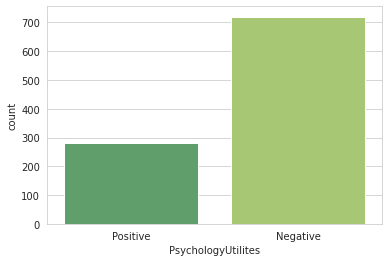

In [22]:
sns.set_style('whitegrid')
sns.countplot(x='PsychologyUtilites',data=df, palette='summer')

In [23]:
df.shape

(1000, 13)

**Construct a pipeline model with count vector Tfidf vector inside**

Pipeline includes vectorization tfidf transformer and SVM training

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import joblib

# A pipeline with data preprocessing, training and prediction
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svm', SVC(C=1))
])

def data_to_pipeline(df, _source=None, _target=None, is_factor=False):
  # Split data for training and validation
  X, y = df[_source].values, df[_target].values
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42) 
  # Training and prediction
  pipeline.fit(X_train, y_train)
  scores = cross_val_score(pipeline, X_test, y_test, cv=3)
  print('now using %s to predict %s' % (_source, _target))
  print('cross validation scores:', scores)
  print('prediction score:', pipeline.score(X_test, y_test))
  print('\n')
  if is_factor:
    joblib.dump(pipeline, _target + '_pipeline.pkl')

In [25]:
def factor_1_pipeline(df):
  data_to_pipeline(df, _source='Statement', _target='Sentiment')
  data_to_pipeline(df, _source='Statement', _target='Confirmation')
  data_to_pipeline(df, _source='Statement', _target='OpinionLeader')
  data_to_pipeline(df, _source='Statement', _target='PsychologyUtilites', is_factor=True)

factor_1_pipeline(df)

now using Statement to predict Sentiment
cross validation scores: [0.92 0.95 0.94]
prediction score: 0.9433333333333334


now using Statement to predict Confirmation
cross validation scores: [0.99 0.98 0.98]
prediction score: 0.99


now using Statement to predict OpinionLeader
cross validation scores: [0.92 0.91 0.92]
prediction score: 0.9166666666666666


now using Statement to predict PsychologyUtilites
cross validation scores: [1.   0.97 0.95]
prediction score: 0.9766666666666667




### Microfactors generation (Mayuri)

**1. Utterance score generation**

Where there are more sentences, there are more utterances. We can derive utterance from numberof sentences in the text.

In [27]:
from collections import Counter
import spacy

nlp = spacy.load('en_core_web_sm')

def get_sentences_num(text):
  _doc = nlp(text)
  sentences = list(_doc.sents)
  return len(sentences)

df['NumOfSent'] = df['Statement'].apply(get_sentences_num)

In [98]:
def gen_microfactor_utterance(df):
  df['ScaleUtterance'] = df['NumOfSent']/df['NumOfSent'].mean()
  df['ScaleUtterancen'] = df['ScaleUtterance'].apply(lambda x: 1 if x > 1 else x)
  df['Utterance'] = df['ScaleUtterance'].apply(lambda x: 'Positive' if x > 0.9 else 'Negative')

gen_microfactor_utterance(df)

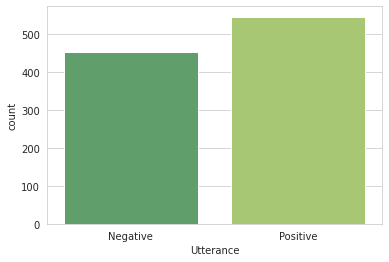

In [99]:
sns.set_style('whitegrid')
sns.countplot(x='Utterance',data=df, palette='summer')

**2.Speech score generation**

Where there are more verbs and nouns, there are more speech to make. We can derive speech from numberof verbs and nouns in the text.

In [30]:
def get_verbnoun_num(text):
  _doc = nlp(text)
  _no_stopword_doc = [token for token in _doc if not token.is_stop]
  return len(_no_stopword_doc)

df['NumOfVerbNoun'] = df['Statement'].apply(get_verbnoun_num)

In [102]:
def gen_microfactor_speech(df):
  df['ScaleSpeech'] = df['NumOfVerbNoun']/df['NumOfVerbNoun'].mean()
  df['ScaleSpeech'] = df['ScaleSpeech'].apply(lambda x: 1 if x > 1 else x)
  df['Speech'] = df['ScaleSpeech'].apply(lambda x: 'Positive' if x > 0.95 else 'Negative')

gen_microfactor_speech(df)

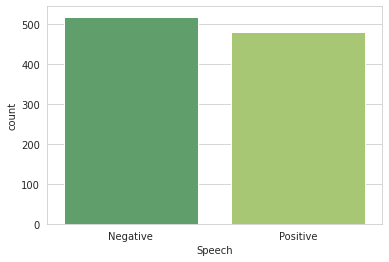

In [103]:
sns.set_style('whitegrid')
sns.countplot(x='Speech',data=df, palette='summer')

**3.Sentiment generation**

Sentiment is a micro factor of intent, also it is micro factor of psychology utility, which has been derived earlier.

In [109]:
df['ScaleSentiment'].head()

0    0.0000
1    0.0000
2    0.3400
3    0.4019
4    0.1363
Name: ScaleSentiment, dtype: float64

### Factor generation(Mayuri)
* Combine micro-factors to factor Intent using polynomial

In [118]:
# Get factor from micro factors by polynomial
df['ScaleIntent'] = df['ScaleUtterancen'] * 0.3 + df['ScaleSpeech'] * 0.3 + df['ScaleSentiment'] * 0.4
df['Intent'] = df['ScaleIntent'].apply(lambda x: 'Positive' if x > 0.65 else 'Negative')

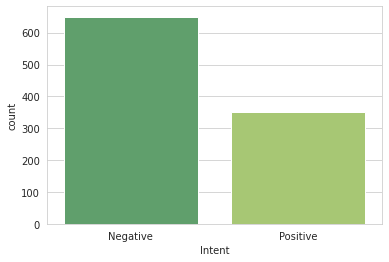

In [119]:
sns.set_style('whitegrid')
sns.countplot(x='Intent',data=df, palette='summer')

In [120]:
def factor_2_pipeline(df):
  data_to_pipeline(df, _source='Statement', _target='Utterance')
  data_to_pipeline(df, _source='Statement', _target='Speech')
  data_to_pipeline(df, _source='Statement', _target='Intent', is_factor=True)

factor_2_pipeline(df)

now using Statement to predict Utterance
cross validation scores: [0.93 0.92 0.93]
prediction score: 0.9233333333333333


now using Statement to predict Speech
cross validation scores: [0.85 0.89 0.91]
prediction score: 0.89


now using Statement to predict Intent
cross validation scores: [0.84 0.9  0.87]
prediction score: 0.9333333333333333




## Apply pipeline on microfactors and factor